Backtest da Estratégia Éden dos Traders.

Fonte de consulta:
https://quantbrasil.com.br/backtest-da-estrategia-de-ifr2-utilizando-medias-moveis-como-filtro/

In [1]:
%%capture
%load_ext blackcellmagic

In [2]:
import yfinance as yf
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

warnings.filterwarnings("ignore")

Definição dos parâmetros de Backtest para a estratégia.

In [3]:
yahoo_finance_download = True
mt5_download = not yahoo_finance_download
save_to_csv = False

initial_capital = 5000
total_capital = [initial_capital]  # list with the total capital after every operation
all_profits = []  # list with the results of every operation

ticker, is_stock, start, end = "BOVA11.SA", True, "2019-04-08", "2024-04-06"

round_entry = False # arredondar o tamanho da posição para lotes múltiplos de 100
position_after_opposite_candle = True  # abrir posição somente quando o candle anterior for contra a tendência
apply_stop = True  # usar o tamanho do candle anterior como cálculo para stop fixo
stop_percent = 0.55  # define o tamanho do stop em uma vez e meia o tamanho do candle anterior

In [4]:
if yahoo_finance_download:
    df = yf.download(ticker, start, end)[["Open", "High", "Low", "Close"]]

[*********************100%%**********************]  1 of 1 completed


In [5]:
from datetime import datetime

import MetaTrader5 as mt5
import pandas as pd

if mt5_download:
    # establish connection to MetaTrader 5 terminal
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        quit()

    # create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
    utc_from = datetime.strptime(start, "%Y-%m-%d")
    utc_to = datetime.strptime(end, "%Y-%m-%d")

    # get bars from BOVA11.SA M5 within the interval of 2020.01.10 00:00 - 2020.01.11 13:00 in UTC time zone
    rates = mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, utc_from, utc_to)

    # shut down connection to the MetaTrader 5 terminal
    mt5.shutdown()

    # create DataFrame out of the obtained data
    df = pd.DataFrame(rates)

    # convert time in seconds into the 'datetime' format
    df["time"] = pd.to_datetime(df["time"], unit="s").dt.normalize()

    df.drop(columns=["tick_volume", "spread", "real_volume"], inplace=True)

    df.rename(
        columns={
            "time": "Date",
            "open": "Open",
            "high": "High",
            "low": "Low",
            "close": "Close",
        },
        inplace=True,
    )

Cálculo das Médias Móveis Exponenciais de 8 e 80.

In [6]:
df['MME80'] = df["Close"].ewm(span=80).mean()
df['MME8'] = df["Close"].ewm(span=8).mean()

Calcular a variação de cada média, pois assim saberemos se ela está subindo (variação > 0) ou não.

In [7]:
df["Variation 8"] = df["MME8"].pct_change()
df["Variation 80"] = df["MME80"].pct_change()

In [8]:
def _buy_strategy(data):
    condition_1 = df["Variation 8"].shift(1) > 0
    condition_2 = df["Variation 80"].shift(1) > 0
    condition_3 = df["MME8"].shift(1) > df["MME80"].shift(1)
    condition_4 = (
        df["Close"].shift(1) < df["Open"].shift(1)
        if position_after_opposite_candle
        else True
    )

    all_conditions = condition_1 & condition_2 & condition_3 & condition_4

    data["Operation"] = np.where(all_conditions, "Buy", np.nan)

    data["Stop Price"] = np.where(
        all_conditions,
        data["Open"] - ((data["High"].shift(1) - data["Low"].shift(1)) * stop_percent),
        np.nan,
    )

    # Define exact buy price
    data["Entry Price"] = np.where(all_conditions, data["Open"], np.nan)

    # Define exact sell price
    if apply_stop:
        data["Exit Price"] = np.where(
            all_conditions,
            np.where(
                data["Low"] <= data["Stop Price"], data["Stop Price"], data["Close"]
            ),
            np.nan,
        )
    else:
        data["Exit Price"] = np.where(
            all_conditions,
            data["Close"],
            np.nan,
        )

    return data

In [9]:
def _sell_strategy(data):
    condition_1 = df["Variation 8"].shift(1) < 0
    condition_2 = df["Variation 80"].shift(1) < 0
    condition_3 = df["MME8"].shift(1) < df["MME80"].shift(1)
    condition_4 = (
        df["Close"].shift(1) > df["Open"].shift(1)
        if position_after_opposite_candle
        else True
    )

    all_conditions = condition_1 & condition_2 & condition_3 & condition_4

    data["Operation"] = np.where(all_conditions, "Sell", data["Operation"])

    data["Stop Price"] = np.where(
        all_conditions,
        data["Open"] + ((data["High"].shift(1) - data["Low"].shift(1)) * stop_percent),
        data["Stop Price"],
    )

    # Define exact sell price
    data["Entry Price"] = np.where(all_conditions, data["Open"], data["Entry Price"])

    # Define exact buy price
    if apply_stop:
        data["Exit Price"] = np.where(
            all_conditions,
            np.where(
                data["High"] >= data["Stop Price"],
                data["Stop Price"],
                data["Close"],
            ),
            data["Exit Price"],
        )
    else:
        data["Exit Price"] = np.where(
            all_conditions,
            data["Close"],
            data["Exit Price"],
        )

    return data

In [10]:
def strategy_points(data):
    data = _buy_strategy(data)
    data = _sell_strategy(data)
    return data

Salvar os dados do trades em um arquivo no formato .csv

In [11]:
from datetime import datetime

if save_to_csv:
    strategy_points(df).to_csv(f"eden_dos_traders-{datetime.now().strftime('%Y_%m_%d')}.csv", sep=",", index=False, encoding="utf-8")

Função para arredondar qualquer número para o menor múltiplo de 100.

In [12]:
from math import floor


def round_down(x):
    return int(floor(x / 100.0)) * 100

In [13]:
from math import trunc


def backtest_algorithm(data, initial_capital=initial_capital):
    total_capital = [initial_capital]
    all_profits = [0]

    for i in range(0, len(data)):
        if ~(np.isnan(data["Entry Price"][i])):
            entry = data["Entry Price"][i]
            operation = data["Operation"][i]
            exit = data["Exit Price"][i]
            profit = 0

            if operation in ("Buy", "Sell"):
                if is_stock:
                    shares = (
                        round_down(total_capital[-1] / entry)
                        if round_entry
                        else trunc(total_capital[-1] / entry)
                    )
                    taxes = (0.00025 * shares * entry) + (0.00025 * shares * exit)
                    variation = (exit - entry) if operation == "Buy" else (entry - exit)
                else:
                    shares = 1
                    taxes = (shares * 0.3) * 2
                    variation = ((exit - entry) if operation == "Buy" else (entry - exit)) * 0.2

                profit = (shares * variation) - taxes

            all_profits += [profit]
            current_capital = total_capital[-1]
            total_capital += [current_capital + profit]

    return all_profits, total_capital

In [14]:
def get_drawdown(data, column="Close"):
    data["Max"] = data[column].cummax()
    data["Delta"] = data["Max"] - data[column]
    data["Drawdown"] = 100 * (data["Delta"] / data["Max"])
    max_drawdown = data["Drawdown"].max()
    return max_drawdown

In [15]:
def strategy_test(all_profits, total_capital):
    num_operations = len(all_profits) - 1
    gains = sum(x >= 0 for x in all_profits)
    pct_gains = 100 * (gains / num_operations)
    losses = num_operations - gains
    pct_losses = 100 - pct_gains
    total_profit = sum(all_profits)
    pct_profit = (total_profit / total_capital[0]) * 100

    total_capital = pd.DataFrame(data=total_capital, columns=["total_capital"])
    drawdown = get_drawdown(data=total_capital, column="total_capital")

    return {
        "num_operations": num_operations,
        "gains": gains,
        "pct_gains (%)": pct_gains.round(),
        "losses": losses,
        "pct_losses (%)": pct_losses.round(),
        "total_profit (R$)": total_profit,
        "pct_profit (%)": pct_profit,
        "profit_per_operation": pct_profit / num_operations,
        "drawdown (%)": drawdown,
    }

In [16]:
def capital_plot(total_capital, all_profits):
    cap_evolution = pd.DataFrame({"Capital": total_capital, "Profit": all_profits})
    plt.title("Curva de Capital")
    plt.xlabel("Total Operações")
    cap_evolution["Capital"].plot()

In [17]:
statistics, cap_evolution, df = {}, {}, strategy_points(data=df)

all_profits, total_capital = backtest_algorithm(df)

statistics["Éden dos Traders"] = strategy_test(all_profits, total_capital)

cap_evolution["Éden dos Traders"] = {
    "all_profits": all_profits,
    "total_capital": total_capital,
}

statistics = pd.DataFrame.from_dict(statistics, orient="index").round(2)
statistics

,num_operations,gains,pct_gains (%),losses,pct_losses (%),total_profit (R$),pct_profit (%),profit_per_operation,drawdown (%)
Éden dos Traders,254,107,42.0,147,58.0,-297.28,-5.95,-0.02,17.14


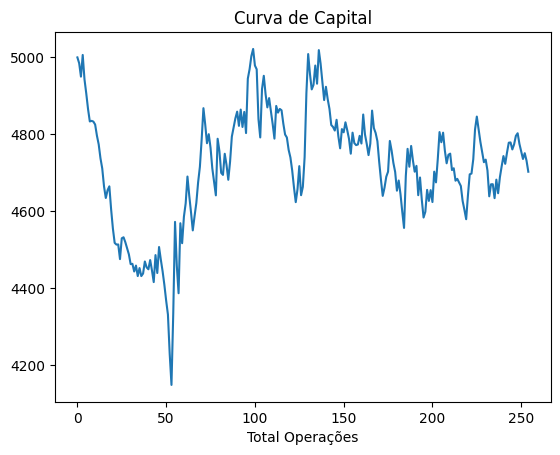

In [18]:
capital_plot(total_capital, all_profits)